# Data Pre-Processing

In [1]:
# Import Packages and CSV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", 100)
# create DataFrame
df = pd.read_csv("marketing_campaign.csv", sep = '\t')
# Print the shape of the data
print(df.shape)

(2240, 29)


## Data Cleaning

### Handling missing values
* **Handling missing values**
* **Handling Duplicates**
* **Check Data type**
* **Understand the dataset**


In [2]:
# Check null values

features_with_na=[features for features in df.columns if df[features].isnull().sum()>=1]
for features in features_with_na:
    print(features, np.round(df[features].isnull().mean()*100, 5), '% missing values')

Income 1.07143 % missing values


In [3]:
# statistics on numerical columns (null columns)
df[features_with_na].select_dtypes(exclude='object').describe()

Income
count    2216.000000
mean    52247.251354
std     25173.076661
min      1730.000000
25%     35303.000000
50%     51381.500000
75%     68522.000000
max    666666.000000

# Imputing the null values

* Impute Median value for Income column

In [4]:
# Income
df.Income.fillna(df.Income.median(), inplace = True)

# Other data cleaning steps

Handling Duplicates

In [5]:
df.duplicated().sum()

np.int64(0)

Remove **Z_CostContact** and **Z_Revenue** columns from the dataset as contains only constant values, therefore doesn't create any variance in the dataset.

In [6]:
columns_to_drop = ['ID', 'Z_CostContact','Z_Revenue']
for column in columns_to_drop:
    df.drop(column, inplace=True, axis=1)
    print(f"COlumn {column} is dropped.")

COlumn ID is dropped.
COlumn Z_CostContact is dropped.
COlumn Z_Revenue is dropped.


# Feature ENgineering

## Feature Extraction
* We will extract and create some of the meaningfull features.

In [7]:

from datetime import datetime

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')

raw_df = df.copy() #saving the raw dataframe for reference


##  creating a new field to store the Age of the customer
df['Age']=2022-df['Year_Birth']   

###  recoding the customer's education level to numeric form (0: high-school, 1: diploma, 2: bachelors, 3: masters, and 4: doctorates)
df["Education"].replace({"Basic":0,"2n Cycle":1, "Graduation":2, "Master":3, "PhD":4},inplace=True)  

#  recoding the customer's marital status to numeric form (0: not living with a partner, 1: living with a partner) 
df['Marital_Status'].replace({"Married":1, "Together":1, "Absurd":0, "Widow":0, "YOLO":0, "Divorced":0, "Single":0,"Alone":0},inplace=True) 

#  creating a new field to store the number of children in the household
df['Children']=df['Kidhome']+df['Teenhome']

#creating Family_Size
df['Family_Size']=df['Marital_Status']+df['Children']+1



#  creating a new field to store the total spending of the customer
df['Total_Spending']=df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]
df["Total Promo"] =  df["AcceptedCmp1"]+ df["AcceptedCmp2"]+ df["AcceptedCmp3"]+ df["AcceptedCmp4"]+ df["AcceptedCmp5"]

# The following code works out how long the customer has been with the company and store the total number of promotions the customers responded to
df['Dt_Customer']=pd.to_datetime(df['Dt_Customer'])
today=datetime.today()
df['Days_as_Customer']=(today-df['Dt_Customer']).dt.days
df['Offers_Responded_To']=df['AcceptedCmp1']+df['AcceptedCmp2']+df['AcceptedCmp3']+df['AcceptedCmp4']+df['AcceptedCmp5']+df['Response']
df["Parental Status"] = np.where(df["Children"] > 0, 1, 0)






#dropping columns which are already used to create new features
columns_to_drop = ['Year_Birth','Kidhome','Teenhome']
df.drop(columns = columns_to_drop, axis = 1, inplace=True)
df.rename(columns={"Marital_Status": "Marital Status","MntWines": "Wines","MntFruits":"Fruits",
                   "MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets",
                   "MntGoldProds":"Gold","NumWebPurchases": "Web","NumCatalogPurchases":"Catalog",
                   "NumStorePurchases":"Store","NumDealsPurchases":"Discount Purchases"},
          inplace = True)

df = df[["Age","Education","Marital Status","Parental Status","Children","Income","Total_Spending","Days_as_Customer","Recency","Wines","Fruits","Meat","Fish","Sweets","Gold","Web","Catalog","Store","Discount Purchases","Total Promo","NumWebVisitsMonth"]]


# Type of Features

* Numeric Features

In [8]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']

print('Num of Numerical Features: ', len(num_features))

Num of Numerical Features:  21


* Categorical Features

In [9]:
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of categorical features: ', len(cat_features))

Num of categorical features:  0


* Discrete Features

In [10]:
discrete_features = [feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete Features: ', len(discrete_features))

Num of Discrete Features:  10


* Continuous Features 

In [11]:
continuous_features = [feature for feature in df.columns if feature not in discrete_features]
print('Num of continuous features: ', len(continuous_features))

Num of continuous features:  11


In [12]:
continuous_features

['Age',
 'Income',
 'Total_Spending',
 'Days_as_Customer',
 'Recency',
 'Wines',
 'Fruits',
 'Meat',
 'Fish',
 'Sweets',
 'Gold']

# Outliers Detection

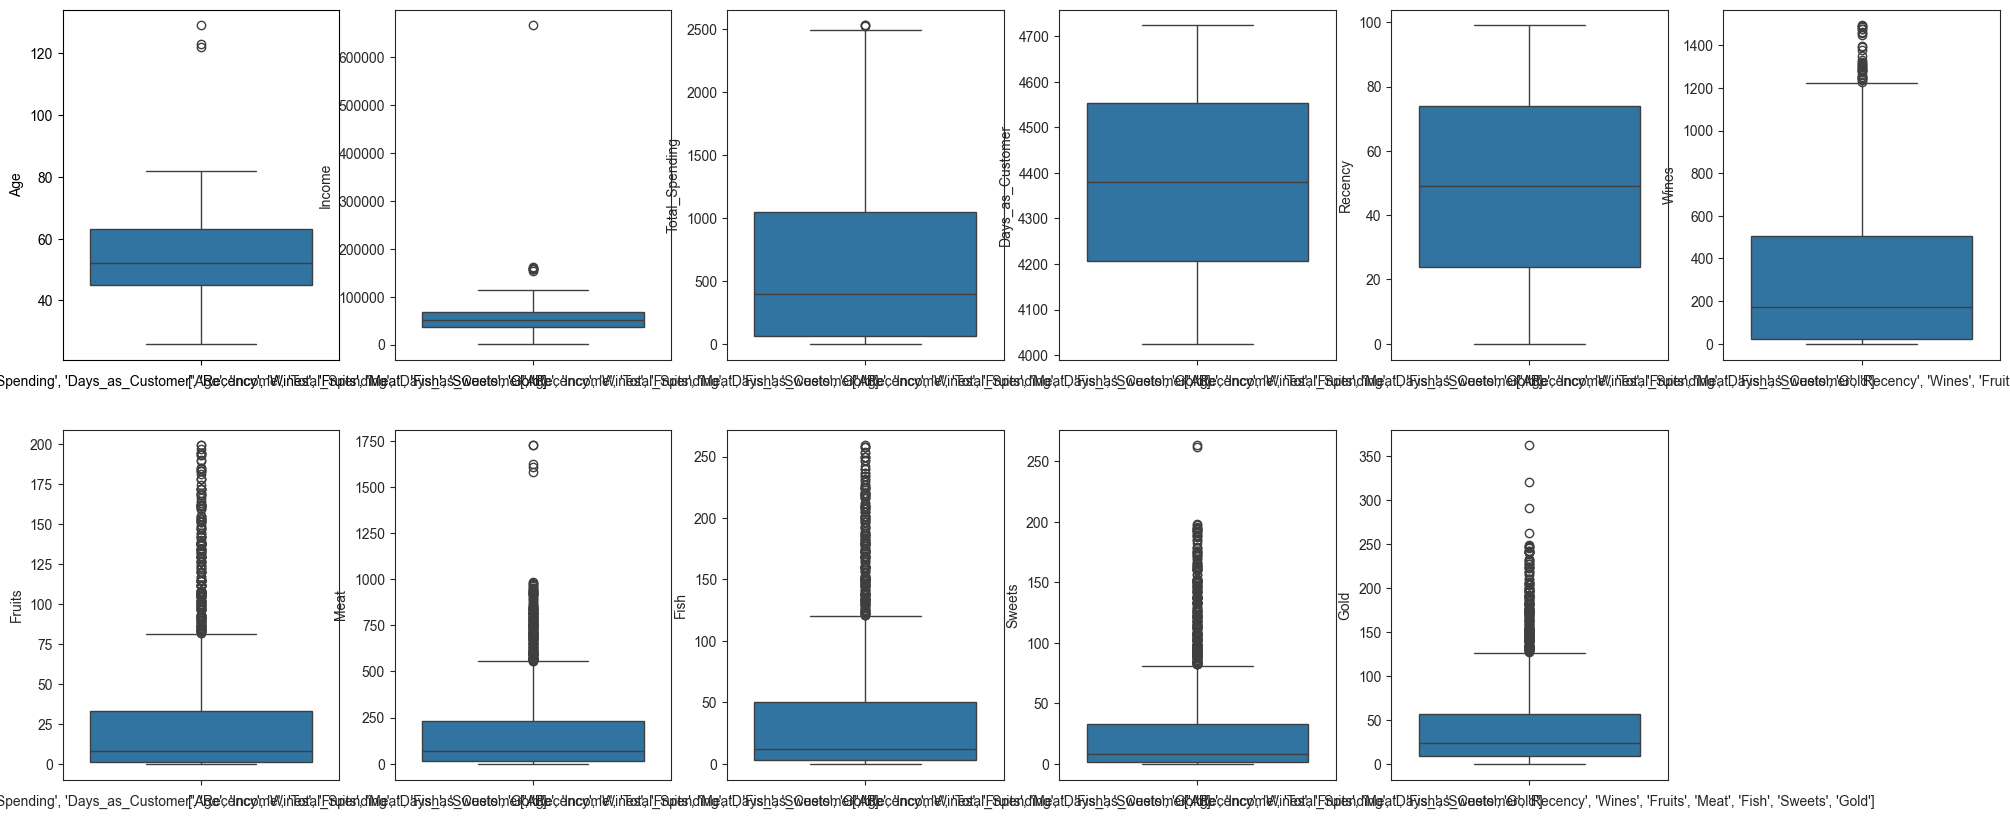

In [13]:
cont_features = continuous_features.copy()
plt.figure(figsize=(25,10))

for i in range(len(cont_features)):
    plt.subplot(2, 6, i+1)
    sns.set_style('ticks')
    plt.xlabel(cont_features)
    ax = sns.boxplot(df[cont_features[i]])

Report 
* We can see, there are no such outliers in **Recency** and **Days_as_Customer** Column 
* But there are outliers in other columns

#### Detecting Outliers and Capping it

In [14]:
def detect_outliers(col):
    # Finging the IQR
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)
    print("\n ####", col, "####")
    print("Percentile25", percentile25)
    print("Percentile75", percentile75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5*iqr
    lower_limit = percentile25 - 1.5*iqr
    print("Upper limit", upper_limit)
    print("Lower limit", lower_limit)
    df.loc[(df[col]>upper_limit, col)] = upper_limit
    df.loc[(df[col]<lower_limit, col)] = lower_limit
    return df 


In [15]:
for col in continuous_features:
    detect_outliers(col)


 #### Age ####
Percentile25 45.0
Percentile75 63.0
Upper limit 90.0
Lower limit 18.0

 #### Income ####
Percentile25 35538.75
Percentile75 68289.75
Upper limit 117416.25
Lower limit -13587.75

 #### Total_Spending ####
Percentile25 68.75
Percentile75 1045.5
Upper limit 2510.625
Lower limit -1396.375

 #### Days_as_Customer ####
Percentile25 4205.75
Percentile75 4554.0
Upper limit 5076.375
Lower limit 3683.375

 #### Recency ####
Percentile25 24.0
Percentile75 74.0
Upper limit 149.0
Lower limit -51.0

 #### Wines ####
Percentile25 23.75
Percentile75 504.25
Upper limit 1225.0
Lower limit -697.0

 #### Fruits ####
Percentile25 1.0
Percentile75 33.0
Upper limit 81.0
Lower limit -47.0

 #### Meat ####
Percentile25 16.0
Percentile75 232.0
Upper limit 556.0
Lower limit -308.0

 #### Fish ####
Percentile25 3.0
Percentile75 50.0
Upper limit 120.5
Lower limit -67.5

 #### Sweets ####
Percentile25 1.0
Percentile75 33.0
Upper limit 81.0
Lower limit -47.0

 #### Gold ####
Percentile25 9.0
Percenti

#### **Checking Skewness after data capping**

In [16]:
df[continuous_features].skew(axis = 0, skipna = True)

Age                 0.120199
Income              0.090027
Total_Spending      0.860245
Days_as_Customer   -0.015216
Recency            -0.001987
Wines               1.096611
Fruits              1.233953
Meat                1.213585
Fish                1.230822
Sweets              1.213346
Gold                1.111307
dtype: float64

## Feature Transformation


### Scaling 
- **What is Feature Scaling**
    - Feature scaling is a method used to normalize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step.
- **Why we use feature scaling?**
    - the feature scaling was implemented to prevent any skewness in the contour plot of the cost function which affects the gradient descent but the analytical solution using normal equation does not suffer from the same drawback.



    - StandardScaler
StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation.

- PowerTransformer
Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

- ColumnTransformer
Applies transformers to columns of an array or pandas DataFrame. This estimator allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space.

- SimpleImputer
SimpleImputer is a scikit-learn class which is helpful in handling the missing data in the predictive model dataset. It replaces the NaN values with a specified placeholder.

- Pipeline
The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. For this, it enables setting parameters of the various steps using their names and the parameter name separated by a '__' .

In [17]:
numeric_features =  [feature for feature in df.columns if df[feature].dtype != 'O']
outlier_features = ["Wines", "Fruits", "Meat", "Fish", "Sweets", "Gold", "Age", "Total_Spending"]
numeric_features = [x for x in numeric_features if x not in outlier_features]

In [18]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


dataC = df.copy()

numeric_pipeline = Pipeline(
    steps = [("Imputer", SimpleImputer(strategy="constant", fill_value = 0)),
             ("StandardScaler", StandardScaler())])

outlier_features_pipeline = Pipeline(steps = [
    ("Imputer", SimpleImputer(strategy='constant', fill_value=0)),
    ("transformer", PowerTransformer(standardize = True))
])

preprocessor = ColumnTransformer([
    ("numeric pipeline", numeric_pipeline, numeric_features),
    ("Outliers Features Pipeline", outlier_features_pipeline, outlier_features)
])


columns = dataC.columns
dataC = preprocessor.fit_transform(dataC)
scaled_data = pd.DataFrame(dataC, columns = columns)
print("After Scaling, lets have a glimpse of the scaled dataaset")
scaled_data.head()

After Scaling, lets have a glimpse of the scaled dataaset


Age  Education  Marital Status  Parental Status  Children    Income  \
0 -0.458383  -1.346874       -1.584605        -1.264505  0.299651  1.531185   
1 -0.458383  -1.346874        0.631072         1.396361 -0.263808 -1.190545   
2 -0.458383   0.742460       -1.584605        -1.264505  0.943420 -0.205773   
3 -0.458383   0.742460        0.631072         0.065928 -1.204881 -1.061881   
4  1.533425   0.742460        0.631072         0.065928  0.307056 -0.953012   

   Total_Spending  Days_as_Customer   Recency     Wines    Fruits      Meat  \
0        0.307039          1.409304  2.510890 -0.550785  0.349414 -0.439037   
1       -0.383664         -1.110409 -0.568720 -1.166125 -0.168236 -0.439037   
2       -0.798086          1.409304 -0.226541  1.295237 -0.685887 -0.439037   
3       -0.798086         -0.750450 -0.910898 -0.550785 -0.168236 -0.439037   
4        1.550305          0.329427  0.115638  0.064556  1.384715 -0.439037   

       Fish    Sweets      Gold       Web   Catalog     Store  \
0  0.693904  1.062784  1.487681  1.504406  1.493989  1.474200   
1 -0.130463 -1.211545 -1.001121 -1.376502 -0.889143 -0.987648   
2 -0.542647  0.748918  1.145877  0.456428  1.435812  0.579704   
3  0.281720 -1.211545 -0.403311 -0.722233 -0.110828 -0.542753   
4 -0.130463  0.123712  1.058075  0.406278  0.832291  0.741799   

   Discount Purchases  Total Promo  NumWebVisitsMonth  
0            1.196801     1.005341           1.315365  
1           -0.967034     1.239521          -1.441417  
2            0.473642     0.361223           0.661170  
3           -1.069040    -1.315014          -1.117211  
4           -0.368949    -1.033428           0.179322

### Model Building ( Clustering )

We know that our dataset it unsupervised, that means we don't have such target column. So we will be using clustering algorithms first to cluster the dataset and create target levels out of it. 

- What is Clustering?
> Using a clustering algorithm means you're going to give the algorithm a lot of input data with no labels and let it find any groupings in the data it can. Those groupings are called clusters. A cluster is a group of data points that are similar to each other based on their relation to surrounding data points.

Here for Clustering Problem statement, 4 Algorithms are used.

- K-Means Clustering
- Agglomerative Clustering
- Gaussian Mixture
- DBSCAN

### Create a function for Silhouette score plot

- **What is silhouette score**

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In [19]:
# In this function we take it form sklearn page for plotting silhouette with little Modification
# plotting silhouette_plot aside with clustering results in PCA

from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import cm

def silhouette_plot(model, range_n_clusters, X_clustering, pca, **kwargs):
    for n_clusters in range_n_clusters:
        # create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 6)
        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X_clustering) + (n_clusters + 1) *10])
        ax1.set_title("Silhouette Plot for n_clusters = %d" % n_clusters)

        clusterer = model(n_clusters, **kwargs)
        cluster_labels = clusterer.fit_predict(X_clustering)

        silhouette_avg = silhouette_score(X_clustering, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )


        # Compute the Silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_clustering, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(i / float(n_clusters))
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 
                              0, 
                              ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)
            
            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + size_cluster_i / 2., str(i))
            y_lower = y_upper + 10
            ax1.set_title("The silhouette plot for the various clusters.")
            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")


             # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.2,-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
    #     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

        sns.scatterplot(
            x = pca[:, 0],
            y = pca[:, 1],
            hue=cluster_labels,
            palette=sns.color_palette("colorblind", len(set(cluster_labels))),
            alpha=0.7,
            legend="full",
            ax = ax2
        )
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            f"Silhouette analysis for {model.__name__} clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

## PCA (Principal Component Analysis)
There is many high correlation feature so we will use some dimentinality reduction. 
We can use PCA

* Principal Component Analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

* Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize and make analyzing data much easier and faster for machine learning algorithms without extraneous variables to process.

In [28]:
# Applying PCA
from sklearn.decomposition import PCA
df_scaled = scaled_data.copy()
var_ratio={}

for n in range(2, 18):
    pc = PCA(n_components=n)
    df_pca = pc.fit(df_scaled)
    var_ratio[n] = sum(df_pca.explained_variance_ratio_)

    


### Choosing PCA **n_components** and Kmeans **n_cluster** based on clustering metrics

In [29]:
from sklearn.cluster import KMeans
for y in range(2, 8):
    print("PCA with # of components: ", y)
    pca = PCA(n_components=y)
    data_p = pca.fit_transform(df_scaled)
    for x in range(2, 7):
        kmeans = KMeans(n_clusters=x)
        label = kmeans.fit_predict(data_p)
        print('Slihouette-Score for',x, 'Clusters', silhouette_score(data_p, label), '-  Inertia: ',kmeans.inertia_)
    print()

PCA with # of components:  2
Slihouette-Score for 2 Clusters 0.5284155925294396 -  Inertia:  9060.532398429676
Slihouette-Score for 3 Clusters 0.5102088251349817 -  Inertia:  5130.341120371399
Slihouette-Score for 4 Clusters 0.4235513763853105 -  Inertia:  4385.7305864849395
Slihouette-Score for 5 Clusters 0.43007973695130836 -  Inertia:  3305.6431136912593
Slihouette-Score for 6 Clusters 0.3976519881767742 -  Inertia:  2920.873993764473

PCA with # of components:  3
Slihouette-Score for 2 Clusters 0.45449155999951524 -  Inertia:  12744.071809961893
Slihouette-Score for 3 Clusters 0.40639822878410836 -  Inertia:  8794.957847106161
Slihouette-Score for 4 Clusters 0.3363790594370082 -  Inertia:  7596.469994169174
Slihouette-Score for 5 Clusters 0.31878160132962846 -  Inertia:  6305.005888294768
Slihouette-Score for 6 Clusters 0.29804529199588137 -  Inertia:  5773.111032398839

PCA with # of components:  4
Slihouette-Score for 2 Clusters 0.4176887741346978 -  Inertia:  15189.655349631796


* We can go with PCA with 2 components 
* We can go with Kmeans Clusters in range of 4-6 as it has Good Score with lesser Inertia compared to others 

In [30]:
# Reducing The dimentions of the data 
pca_final = PCA(n_components=2, random_state=42).fit(df_scaled)

reduced = pca_final.fit_transform(df_scaled)
pcadf = pd.DataFrame(reduced)
pcadf.columns = ['PC1', 'PC2']
pcadf.head()

PC1       PC2
0  4.130751  0.501059
1 -3.495848 -0.524323
2  3.032352 -0.850799
3 -2.794852 -1.108400
4  0.786683  0.794184

In [31]:
pca_final.explained_variance_ratio_

array([0.39488178, 0.10833485])

# Elbow Method to find the best Clusters for K-Means

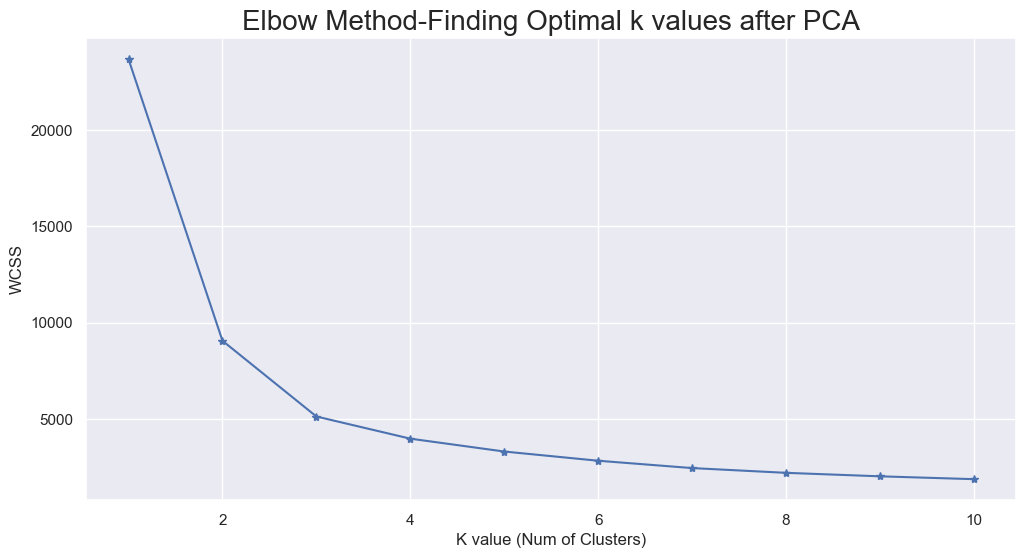

In [32]:
wcss = {}
sns.set()
plt.figure(figsize=(12, 6))
for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km.fit(pcadf)
    wcss[i] = km.inertia_

plt.plot(range(1,11),wcss.values(), marker="*")
plt.title("Elbow Method-Finding Optimal k values after PCA", fontsize = 20)
plt.xlabel('K value (Num of Clusters)')
plt.ylabel('WCSS')
plt.show()

* Here the Optimal number of cluster is 3 

**Reports:**
* We will use k=3
* We will use KMeans Algorithm for clustering.

#### Silhouette Score Plot for K-Means to choose best number of clusters

For n_clusters = 3 The average silhouette_score is : 0.5103338818336768
For n_clusters = 4 The average silhouette_score is : 0.45277333714656554
For n_clusters = 5 The average silhouette_score is : 0.4398022389742095
For n_clusters = 6 The average silhouette_score is : 0.39642417303601907


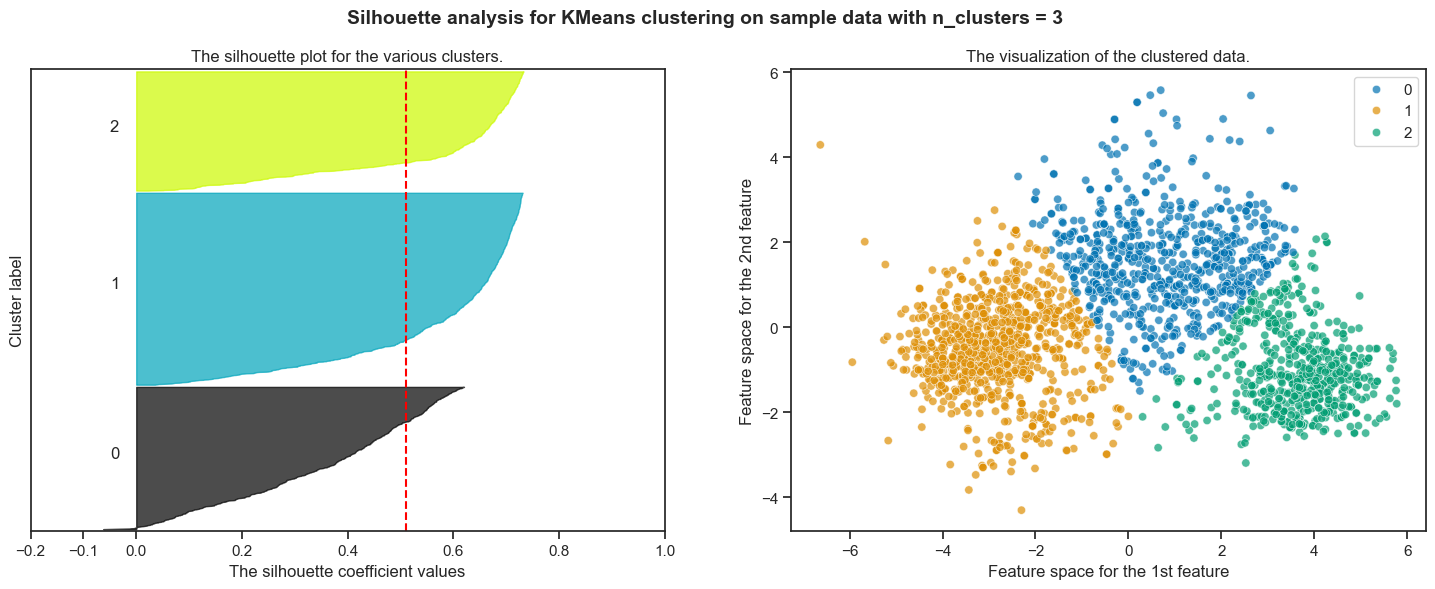

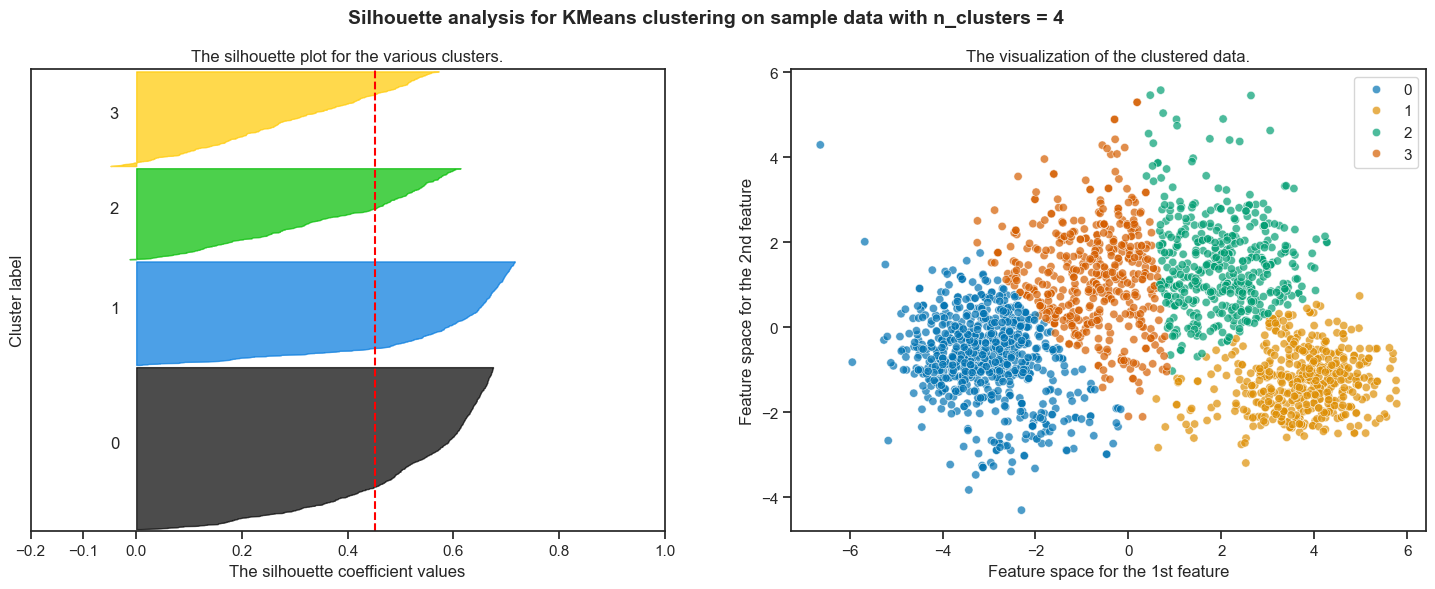

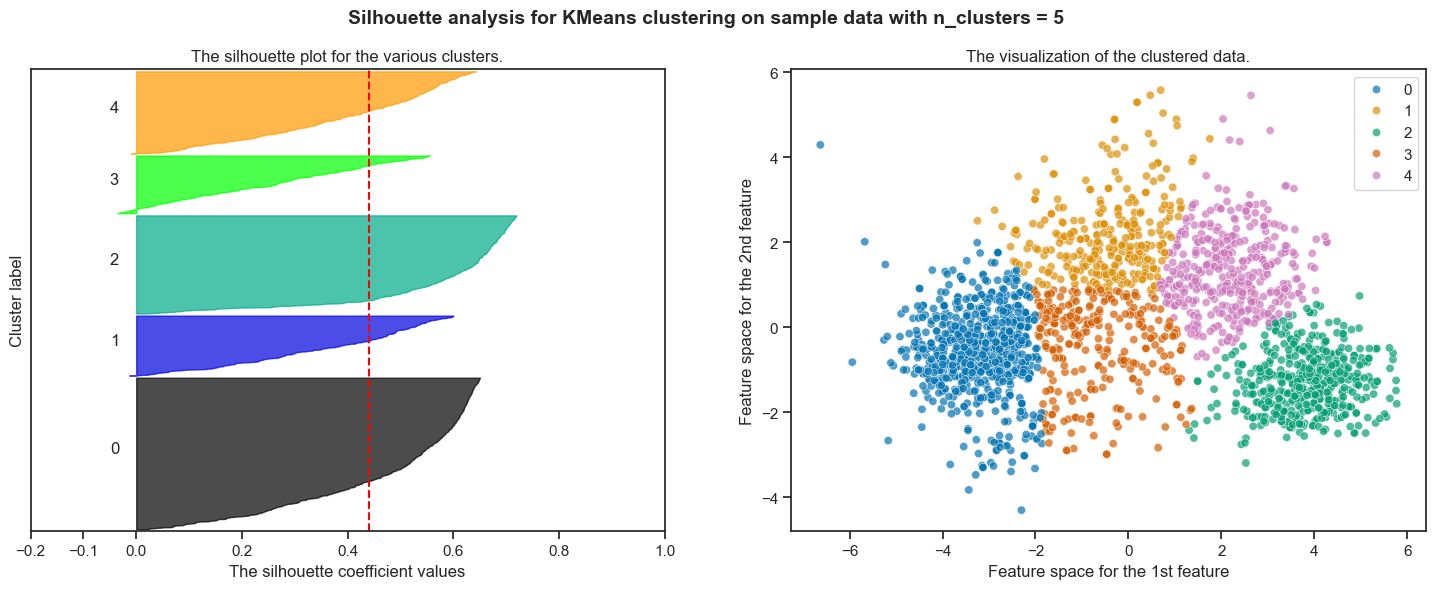

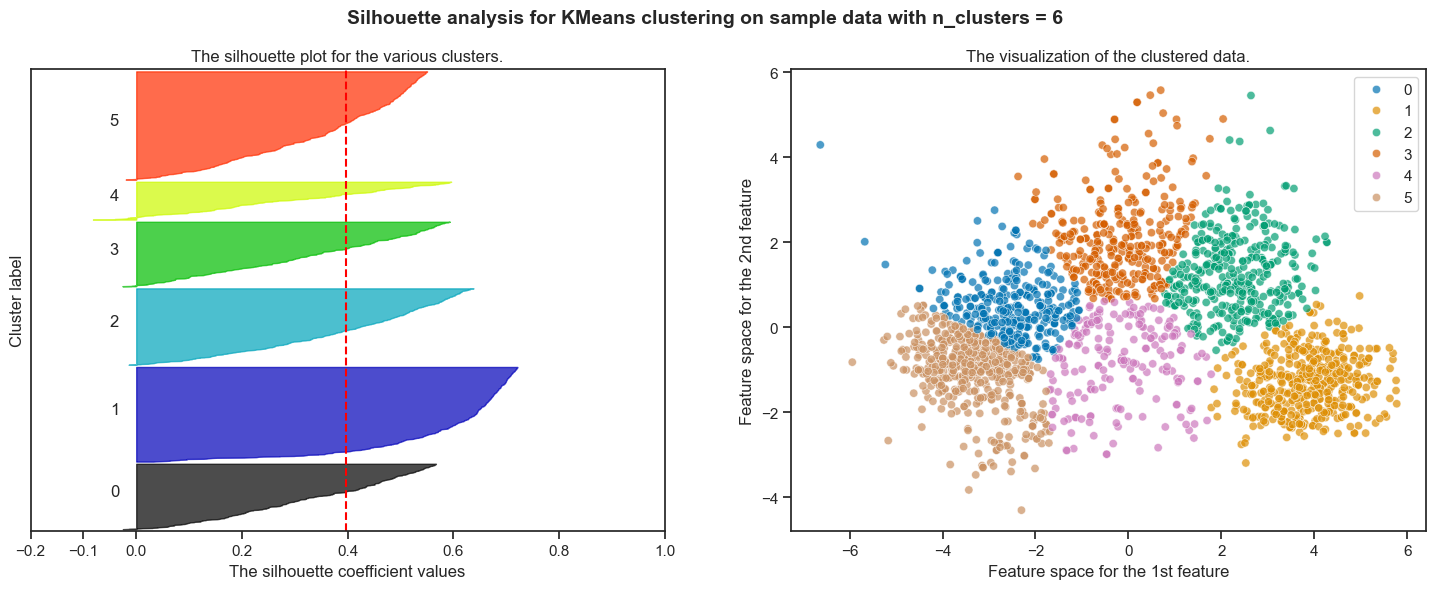

In [43]:
# We plot silhouette score for Kmeans
# Here pcadf is pca dataframe, and Reduced is array of data after PCA.
sns.set_style('ticks')
silhouette_plot(KMeans,range(3,7), pcadf, reduced)

### Apply Kmeans Clustering with 3 clusters

In [34]:
# Fitting the model to reduced data
model = KMeans(n_clusters=3).fit(pcadf)
model_label = model.labels_
model_centers = model.cluster_centers_

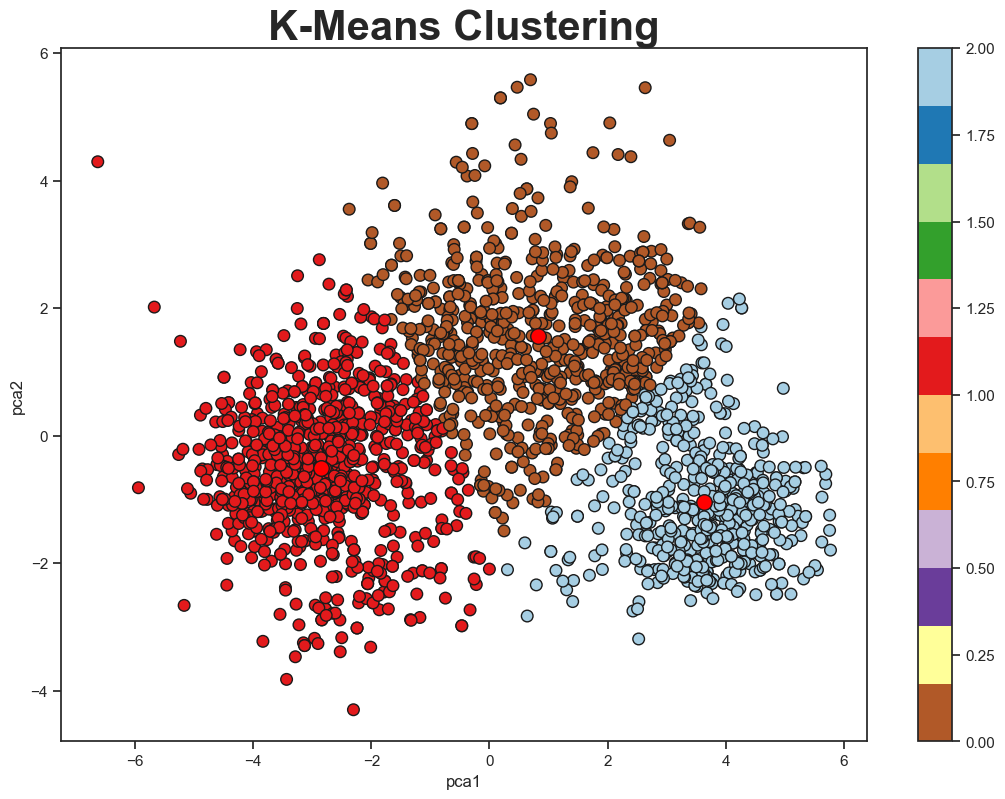

In [ ]:
#Plotting the clusters
plt.figure(figsize=(13,9))
plt.title('K-Means Clustering', weight='bold', size=30)
plt.xlabel('pca1')
plt.ylabel('pca2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c=model_label, s=70, cmap='Paired_r', ec='k')
plt.colorbar(scatter)
plt.scatter(model_centers[:,0], model_centers[:,1], c='red', marker='.',s=500, ec='k')

#### Hierarchical Clustering (Agglomerative) 


#### Silhouette Score Plot for Agglomerative Clustering to choose best number of clusters

* We will go with the n_clusters range of 3-7 to find the best cluster for Agglomerative clustering

For n_clusters = 2 The average silhouette_score is : 0.4812347065596157
For n_clusters = 3 The average silhouette_score is : 0.4731726612944978
For n_clusters = 4 The average silhouette_score is : 0.43908681362953433
For n_clusters = 5 The average silhouette_score is : 0.4165290795347633
For n_clusters = 6 The average silhouette_score is : 0.3936313189545478
For n_clusters = 7 The average silhouette_score is : 0.3896956270745404


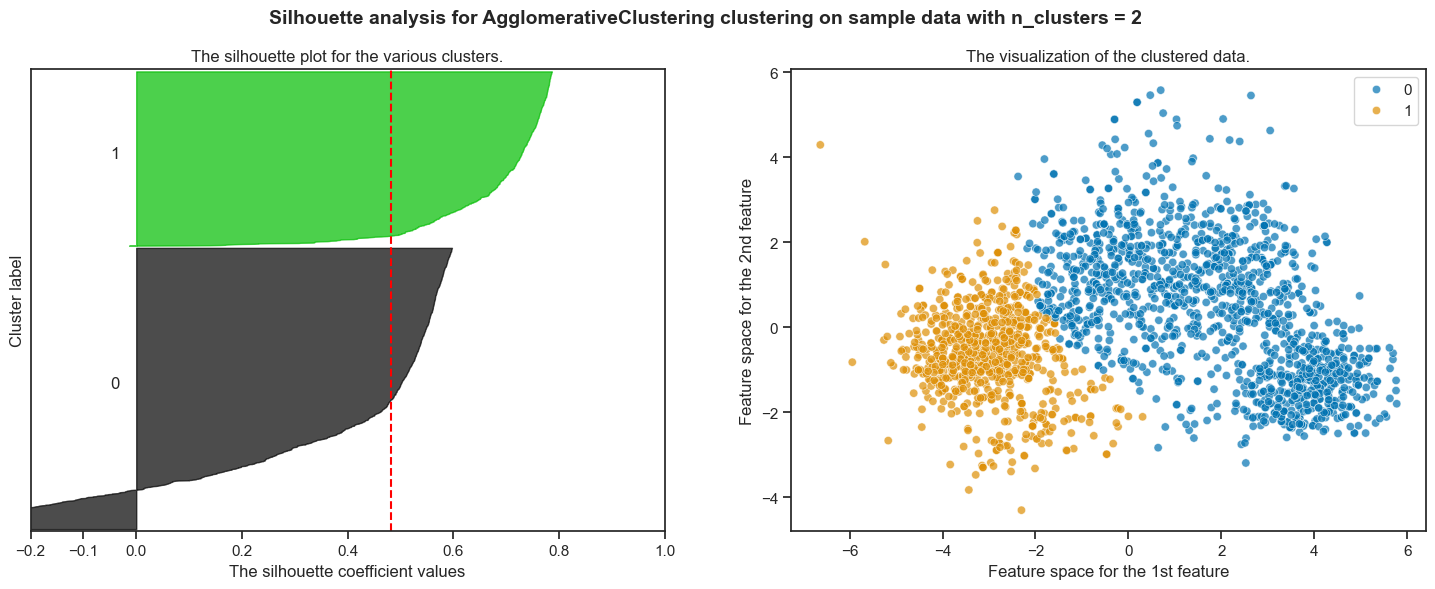

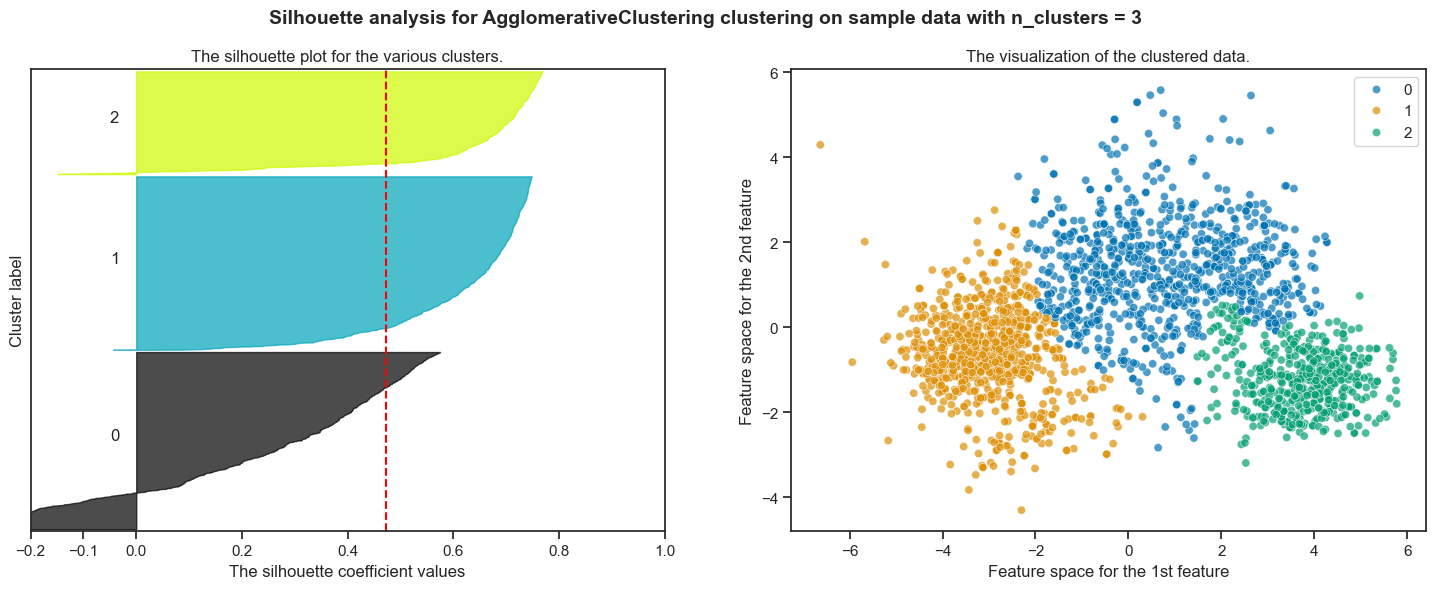

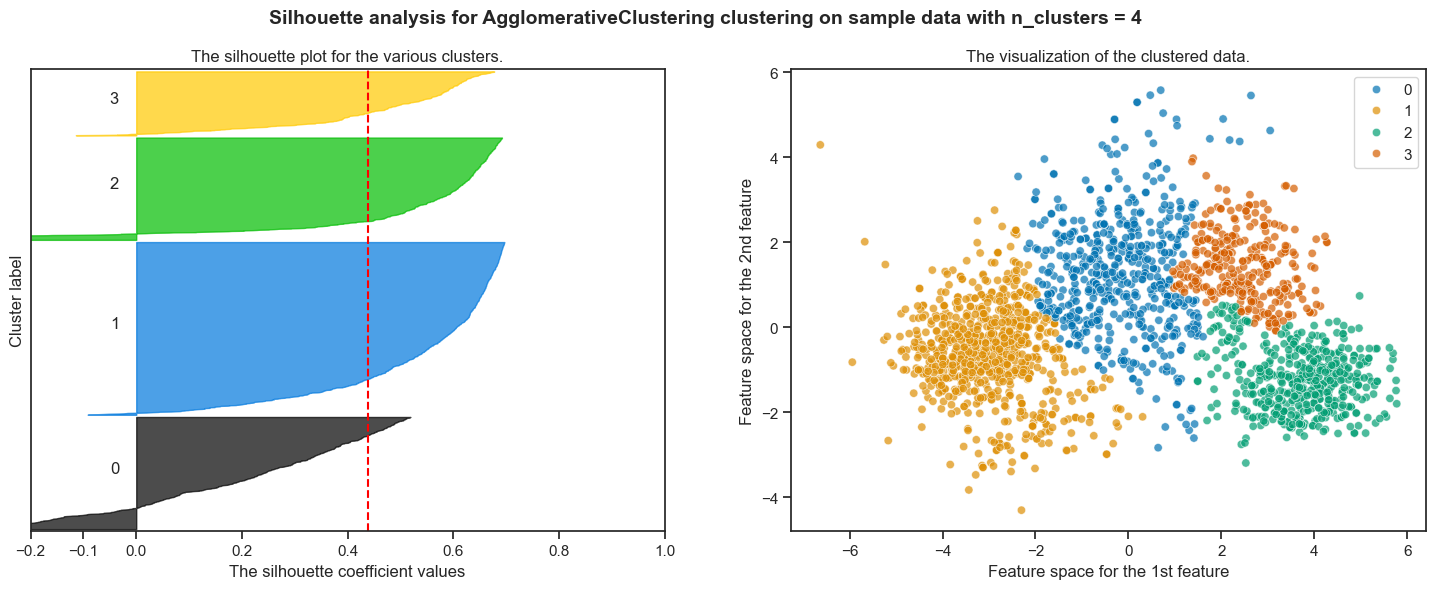

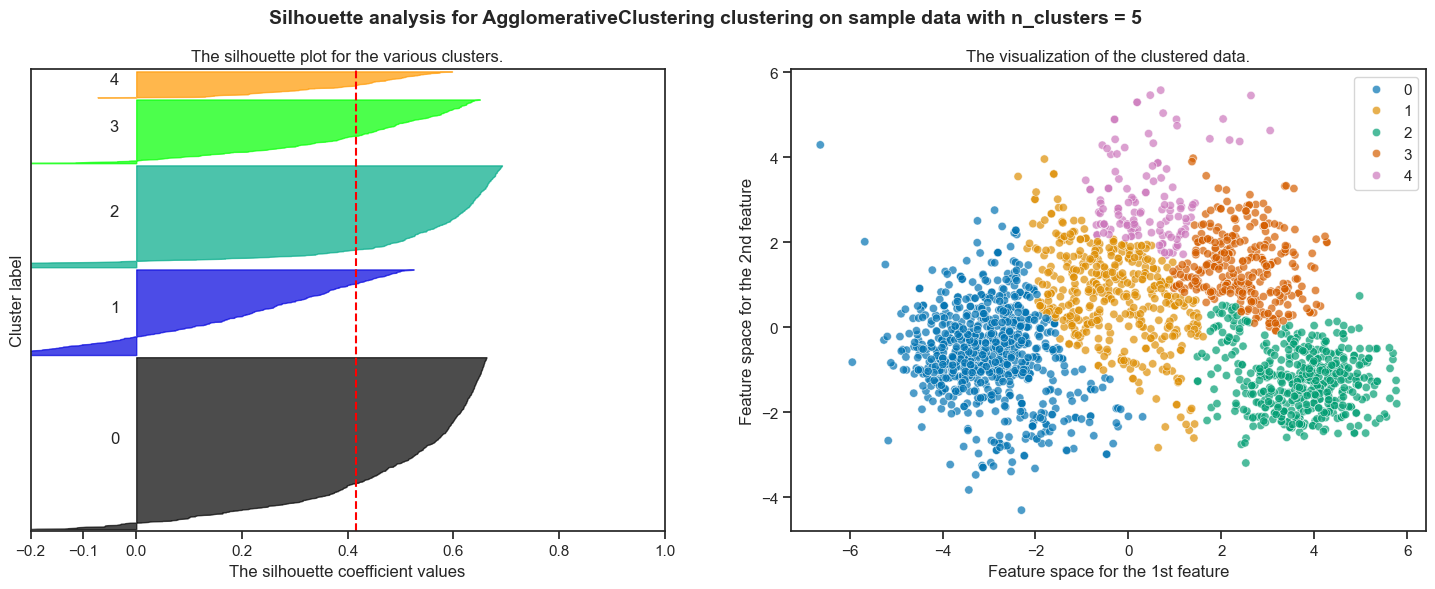

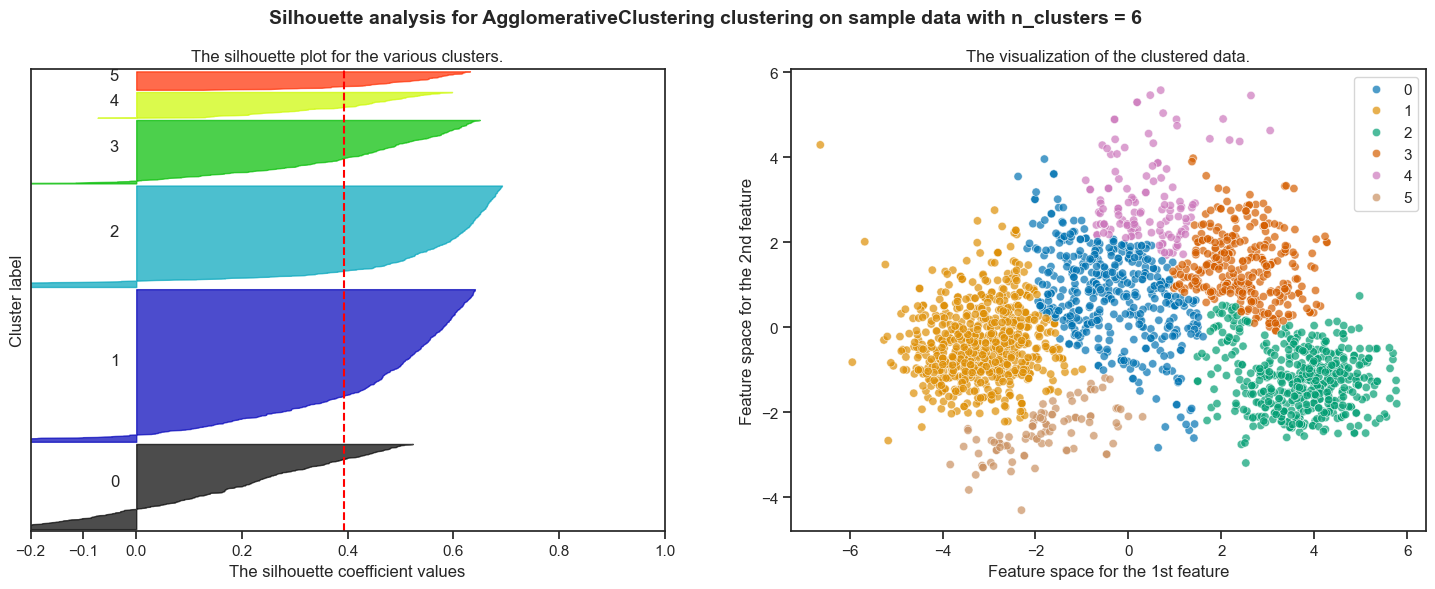

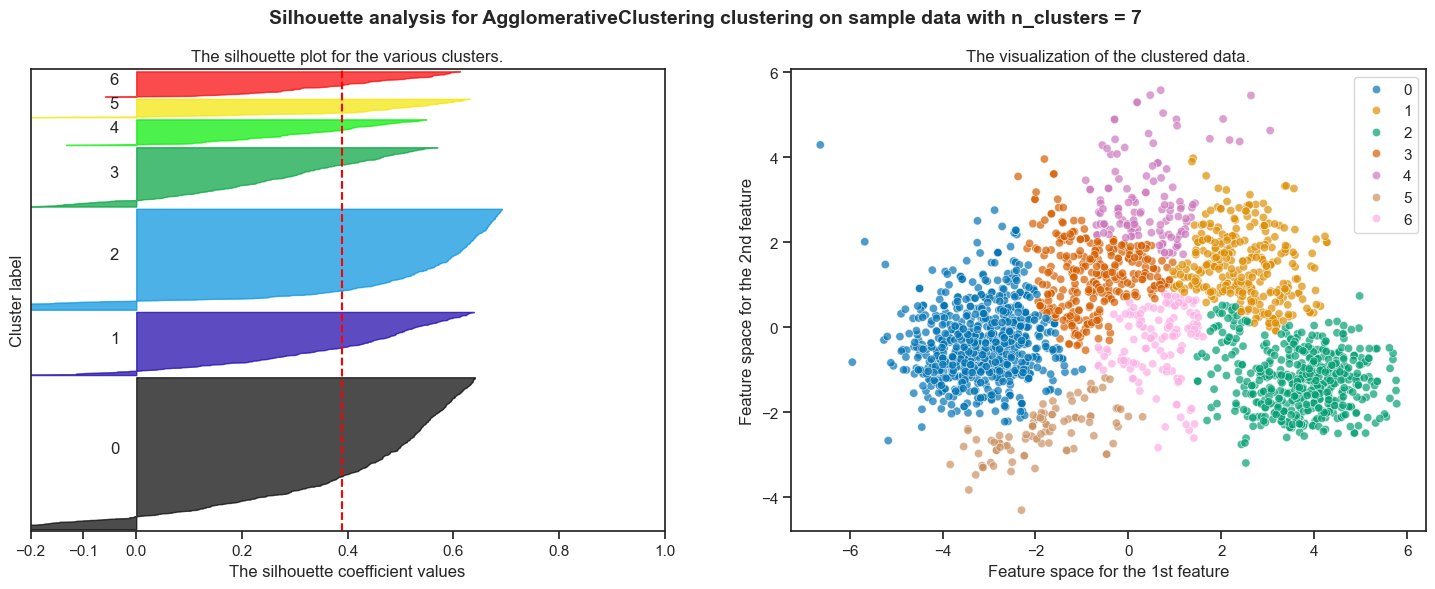

In [45]:
from sklearn.cluster import AgglomerativeClustering
# Plot Score to Choose best clusters
silhouette_plot(AgglomerativeClustering, range(2,8), pcadf, reduced)

* Cluster of 2 has good balance of Inertia and Shilloute score, we can go with 2 clusters

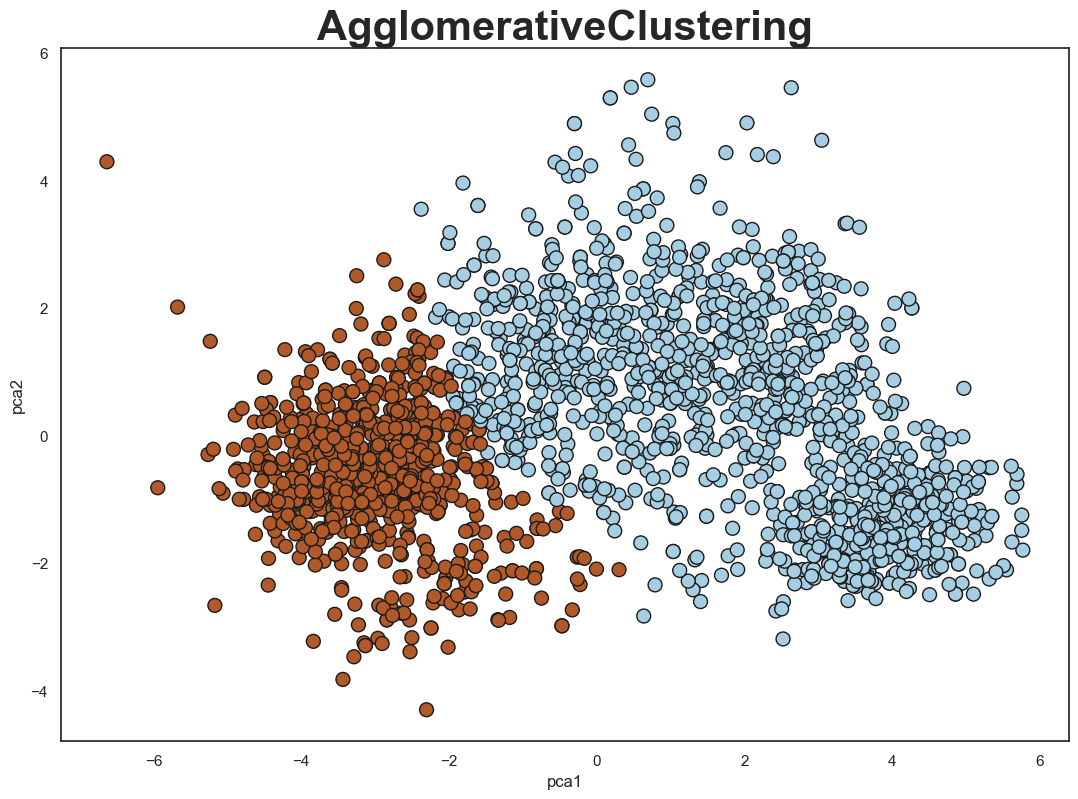

In [41]:
model = AgglomerativeClustering(n_clusters=2, linkage = 'ward').fit(reduced)
model_label = model.labels_
plt.figure(figsize=(13, 9))

sns.set_style('white')
plt.title('AgglomerativeClustering', weight='bold', size = 30)
plt.xlabel('pca1')
plt.ylabel('pca2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c = model_label, s = 100, cmap = 'Paired', ec = 'k')

# Gaussian Mixture 


For n_clusters = 3 The average silhouette_score is : 0.47682993846850813
For n_clusters = 4 The average silhouette_score is : 0.44536988694379287
For n_clusters = 5 The average silhouette_score is : 0.44762797111556046
For n_clusters = 6 The average silhouette_score is : 0.40801457798558427
For n_clusters = 7 The average silhouette_score is : 0.35504817458750093


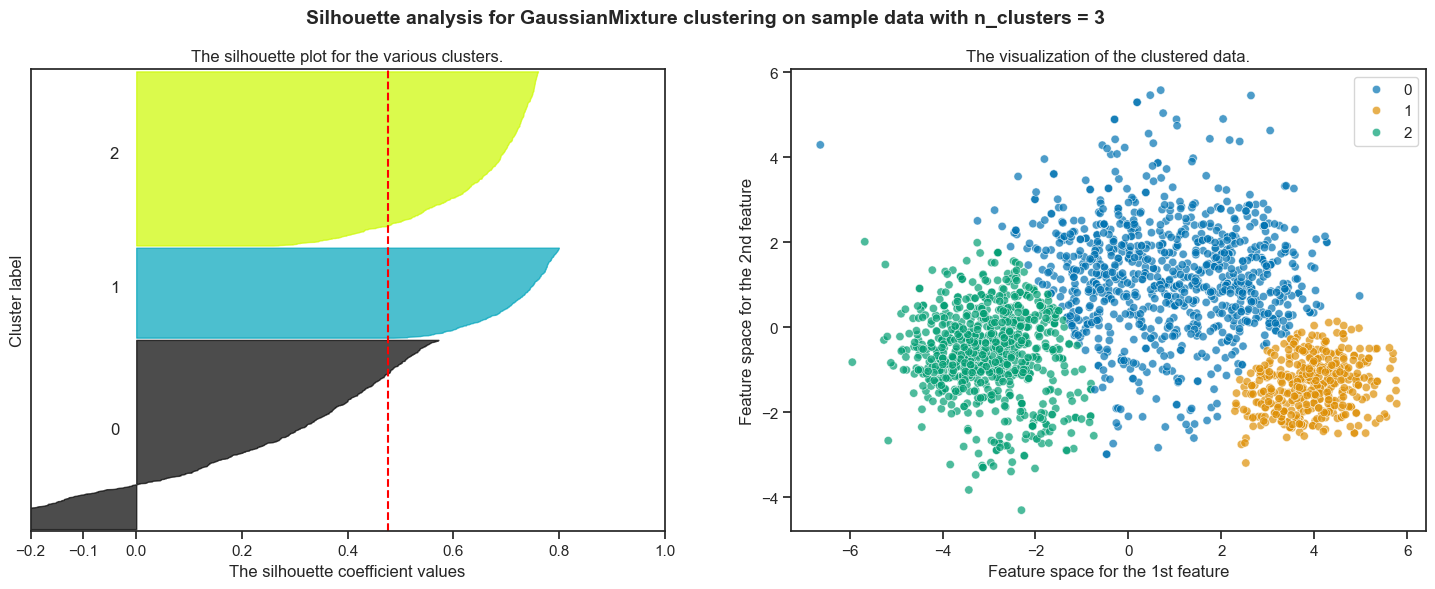

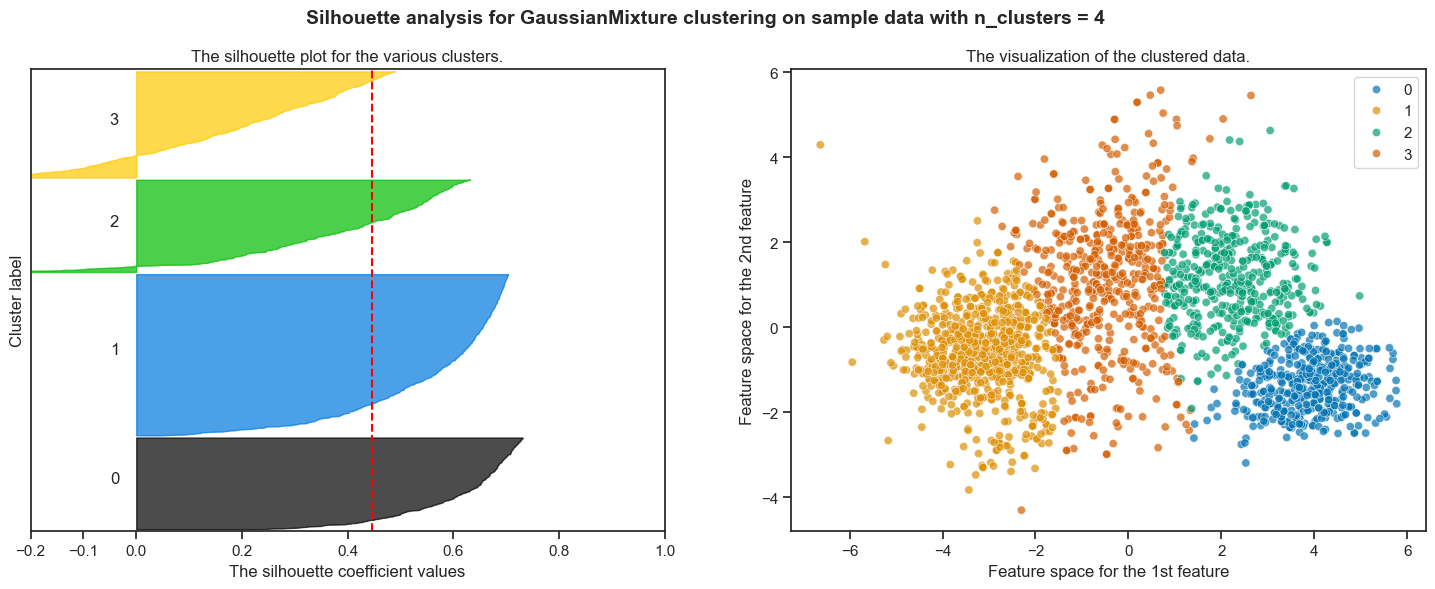

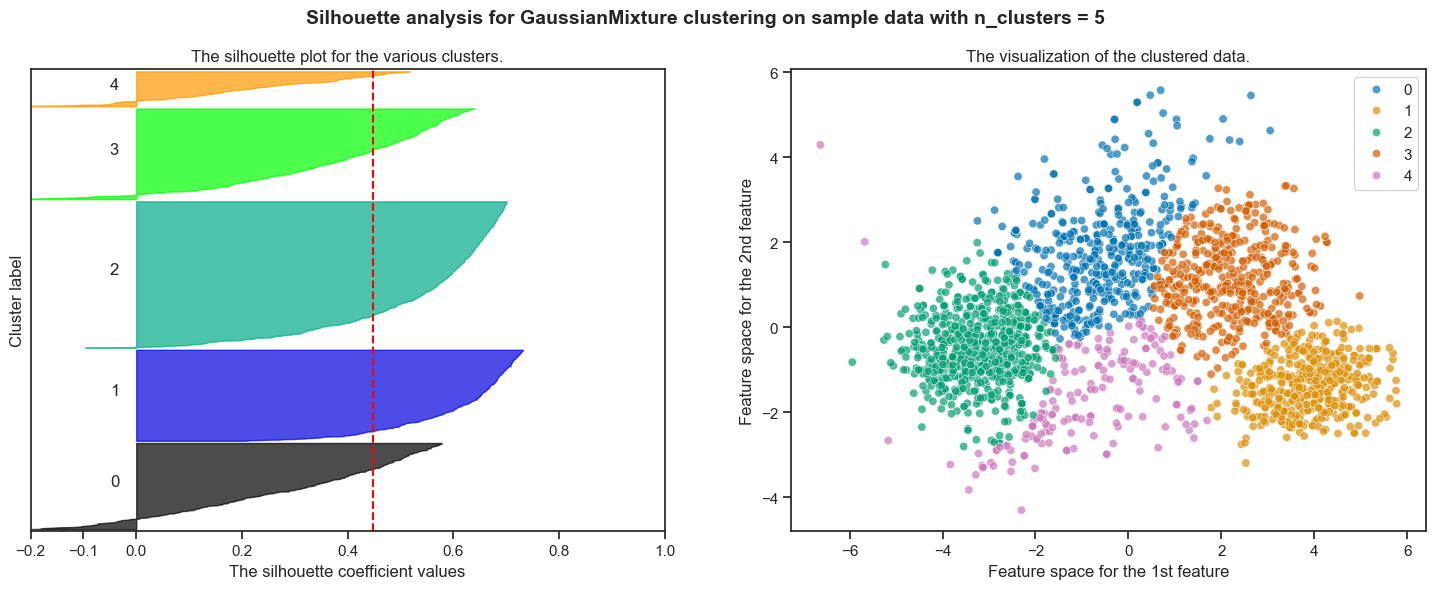

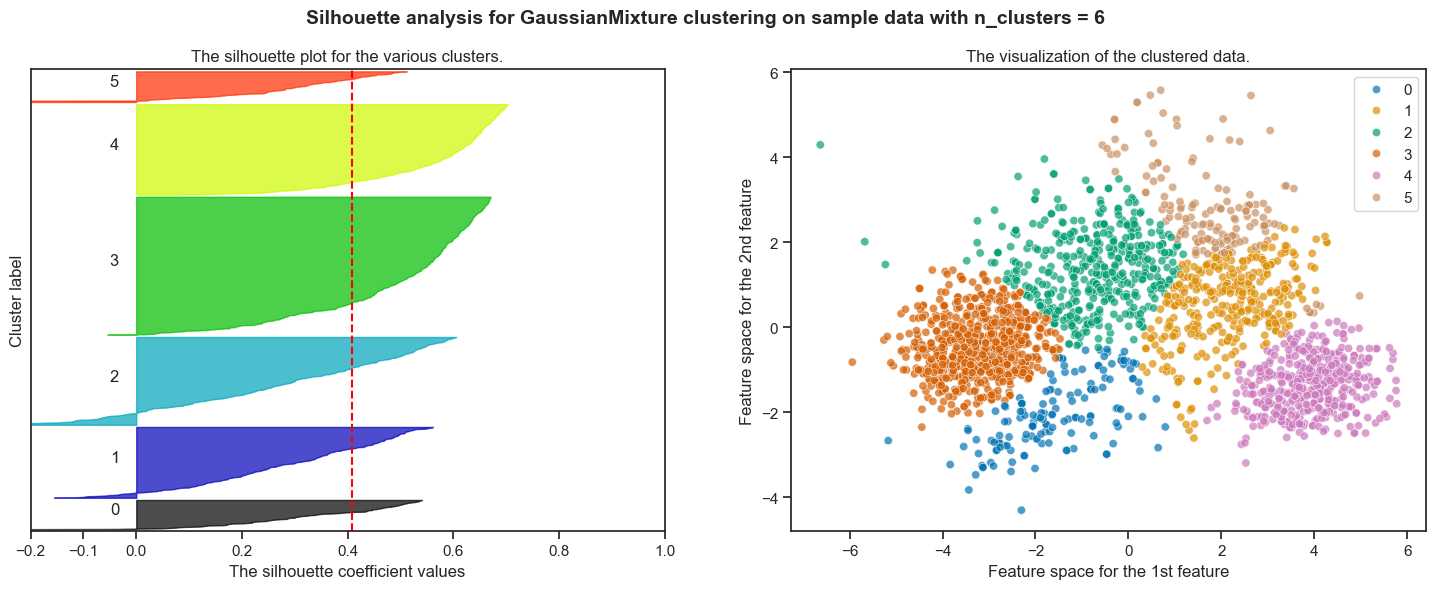

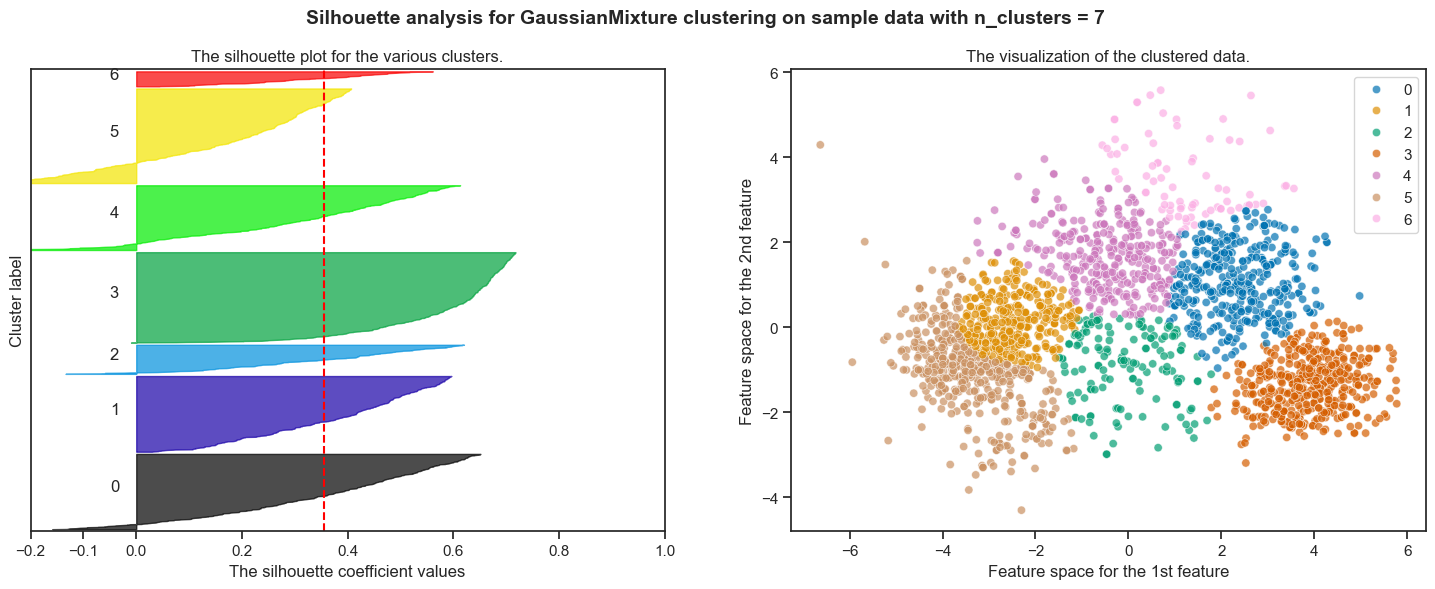

In [50]:
from sklearn.mixture import GaussianMixture
silhouette_plot(GaussianMixture, range(3, 8), pcadf, reduced)

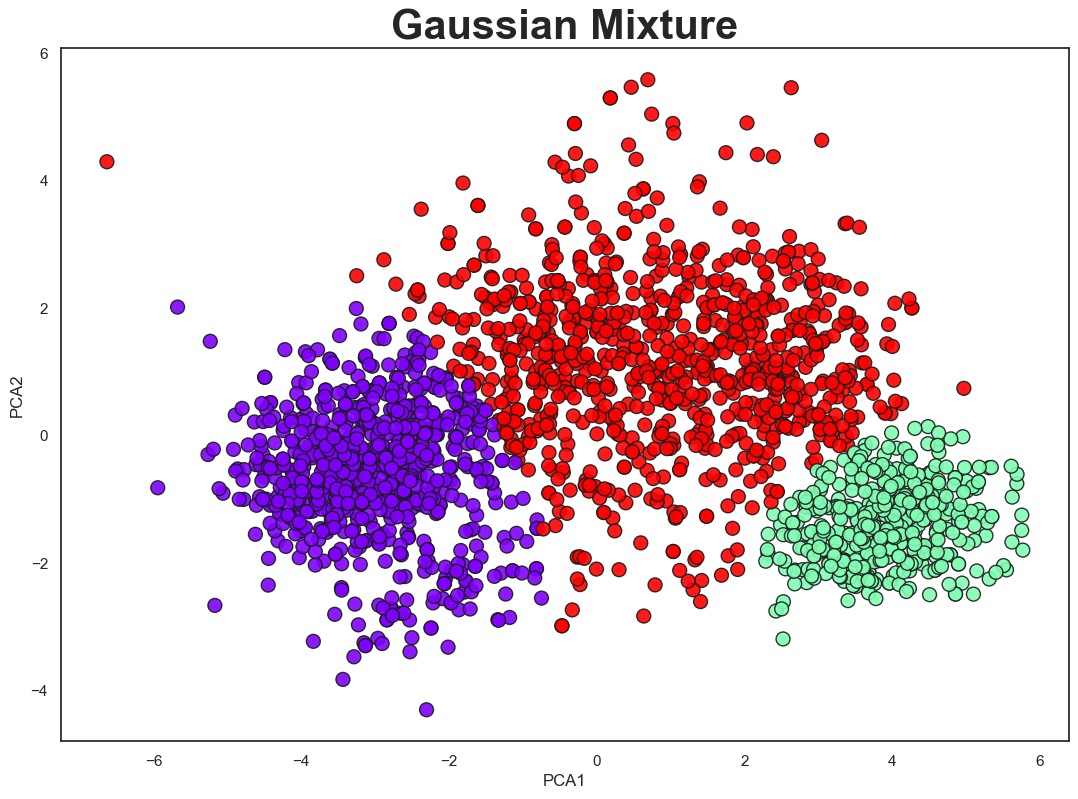

In [53]:
model = GaussianMixture(n_components=3,random_state=42).fit(reduced)
model_label = model.predict(reduced)
plt.figure(figsize=(13,9))

sns.set_style('white')
plt.title('Gaussian Mixture', weight='bold', size=30)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c = model_label, s = 100, cmap='rainbow', ec='k', alpha=0.9)

# DBSCAN 

### Finding the Optimal value of Epsilon

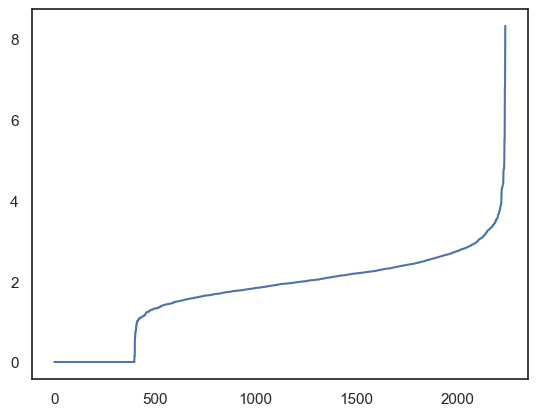

In [54]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

neighbours = NearestNeighbors(n_neighbors=17)
neighbours_fit = neighbours.fit(df_scaled)
distances, indices = neighbours_fit.kneighbors(df_scaled)

distances = np.sort(distances, axis=0)

distances = distances[:, 1]
plt.plot(distances)
plt.show()

#### **Kneedle algorithm**

* We'll use kneedle algorithm here via Kevin Arvai's Python implementation called Kneed. You can download this via Pypi by entering **pip3**
**install kneed** in your terminal and then importing the package.

<Figure size 500x500 with 0 Axes>

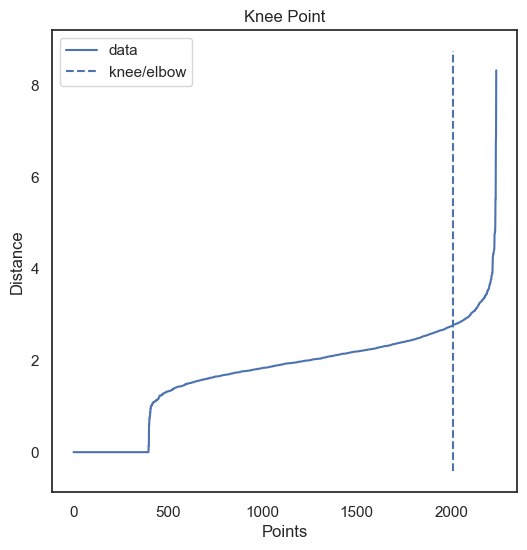

Knee Locator k:  2.7566368787163147


In [56]:
# !pip install kneed

from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances,S=1 ,curve='convex', direction='increasing', interp_method = 'polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k = distances[knee.knee]
print("Knee Locator k: ",k)

#### For 2 dimentional data use DBSCAN's default value of MinPts = 4

**DBSCAN algorithm works with two parameters**

these parameters are

* Epsilon(Eps)
* MinPts

#### Plot using PCA

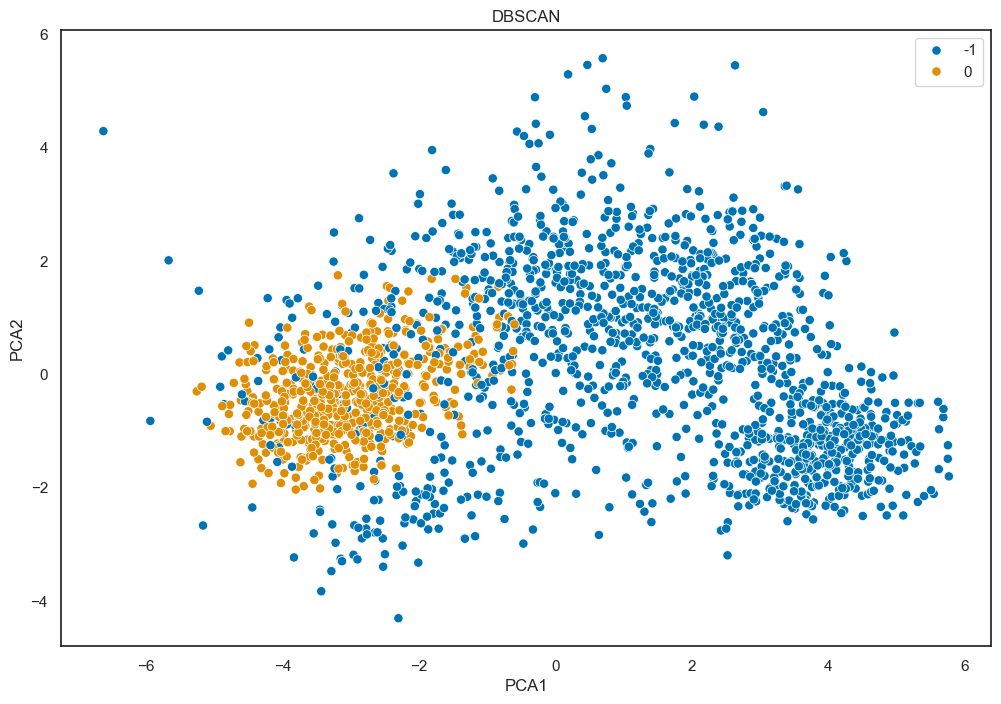

In [65]:
model = DBSCAN(eps=k, min_samples=100).fit(df_scaled)
model_label = model.labels_
plt.figure(figsize=(12, 8))

plt.title('DBSCAN')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

scatter = sns.scatterplot(x = reduced[:, 0], y = reduced[:, 1], hue = model_label, palette= sns.color_palette("colorblind", len(set(model_label))), s = 45)

### DBSCAN did'nt perform well in clustering 

### Final Model

* As Kmeans clustering performed well that rest of the other algorithms, we will go with this

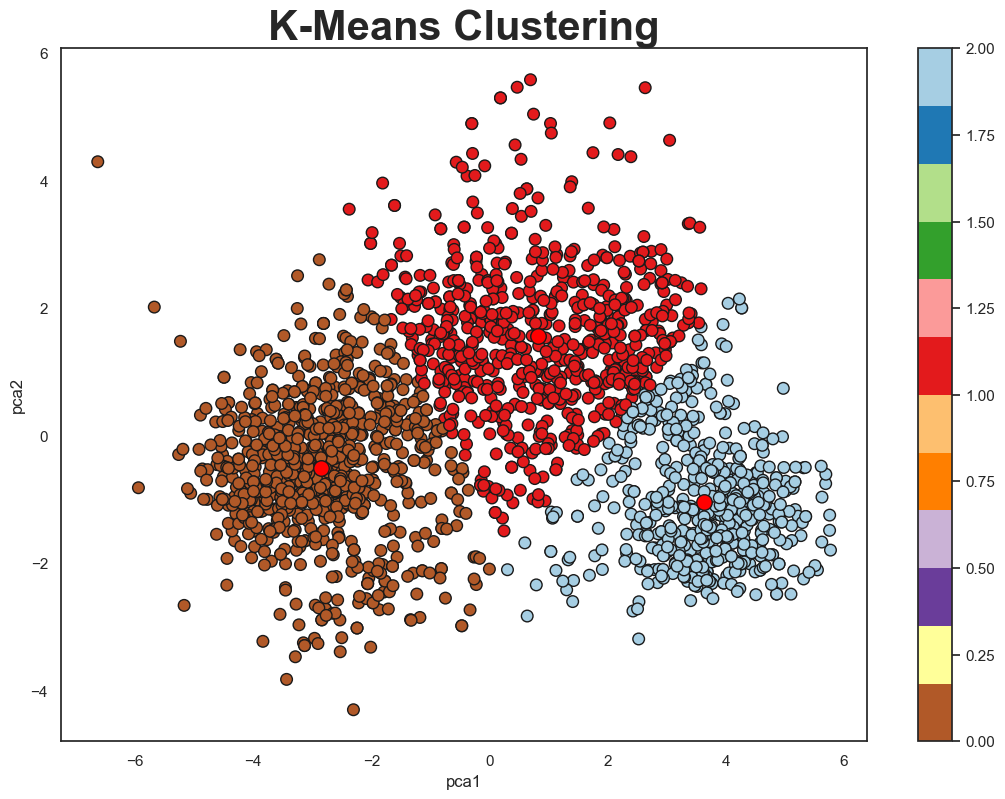

In [67]:
model = KMeans(n_clusters=3).fit(pcadf)
model_label = model.labels_
model_centers = model.cluster_centers_

#Plotting the clusters
plt.figure(figsize=(13,9))
plt.title('K-Means Clustering', weight='bold', size=30)
plt.xlabel('pca1')
plt.ylabel('pca2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c=model_label, s=70, cmap='Paired_r', ec='k')
plt.colorbar(scatter)
plt.scatter(model_centers[:,0], model_centers[:,1], c='red', marker='.',s=500, ec='k')

### Saving the data with cluster column

In [68]:
#save model labels as new feature
import os
df["cluster"] = model.labels_.astype(int)
os.makedirs('data')
df.to_csv("./data/clustered_data.csv", index=False)

### Final report
- As we got the EDA results, we used that same approaches here also. We extracted out some features to derive valuable meanings from the data and used those in model training.
- The data had outliers and multicollinearity, We created pipelines to handle those things
- We have used PCA to minimize the dimensionality of the data.
- Kmeans Clustering algorithm has performed better then rest of the other clustering algorithms. So we went with it.